# K-Means Clustering

This implementation is done without the use of any external libraries. We will only use the builtin random library for generating random numbers and the builtin typing library for type hints for our functions and class methods. This is meant for education and demonstration purposes as it is less efficient and reliable than other established libraries that are based on compiled and parallelized languages like C and are much more complex and optimized.

This model will find k clusters from unlabeled data.

Algorithm overview:

Initialize the cluster centroids

repeat until convergence:
- for each point $x^i$ find the closest centroid and assign it to that cluster

- for each cluster find the mean of all points assigned then update the centroid to that mean.

- criterion for convergence, measure the total movement of all centroids and if less than the threshold exit the loop

In [231]:
import random
from typing import List, Self, Any

## Helper functions
We need a way to generate a random number between two end points. We will do this with a function to generate a random sample of 1 from within the given bounds.

In [232]:
def random_sample(low:int|float, high:int|float) -> float:
    """generate a random sample between low and high

    Args:
        low (int | float): the lower bound of the sample
        high (int | float): the upper bound of the sample

    Returns:
        float: a random number between low and high
    """
    rand_num = low + (high - low) * random.random()
    return rand_num

## Distance function
To calculate the movement of the centroids during training and the distance between points and centroids we need a distance metric. Here we will use the widely used euclidean distance. 

It is defined as:

$$dist(x, y)=\sqrt{\sum_{i=1}^{n}{(x^i - y^i)^2}}$$

In [233]:
def calc_euclidean_dist(point_1:List[float], point_2:List[float]) -> float:
    """calculate the euclidean distance between two n-dimensional points

    Args:
        point_1 (List[float]): n-dimensional coordinates of point_1
        point_2 (List[float]): n-dimensional coordinates of point_2

    Returns:
        float: the euclidean distance between point_1 and point_2

    Notes:
        dist=\\sqrt{\\sum{(x^i - y^i)^2}}
    """

    dist = sum([(point_1[i] - point_2[i])**2 for i in range(len(point_1))]) ** .5

    return dist

## Functions directly used by the kMeans Model
### Now we are going to define four functions that are directly used by the kmeans model.

First we need to be able to initialize the models centroids. This will be done using random initialization. This random Initialization will use the minimum and maximum of each column and generate a random number between them. There are other ways to initialize the centroids and some methods are better than others. For example in scikit-learn implements a "k-means++" initialization which is "based on an empirical probability distribution of the points’ contribution to the overall inertia"(sklearn-documentation). We could also choose k random points from the data, but if lots of the points are spatially together then there is a higher probability that the starting points are all clustered together in that spatially dense area. The simple random initialization we use here is much simpler but can sometimes get stuck if initialized exactly between clusters.

In [234]:
def initialize_centroids(data:List[List[int|float]], k:int) -> List[List[float]]:
    """Initialize cluster centroids this should be 
        done randomly within the range of all points

    Args:
        data (List[List[float]]): the data to initialize the clusters over
        k (int): the number of clusters

    Returns:
        list: initialized cluster centers

    Steps:
        1. initialize min's and max's list with the length m of an nxm matrix i.e the columns
        2. go through each row in the dataset ensuring that each entry is within the range 
        of the min and max of the dataset
        3. for each cluster k initialize a random sample of between the min and max for each column
        4. return the centroid coordinates. this will be a kxn matrix where each row is a centroid 
            and each column if the i'th coordinate for that cluster
    Notes:
        We don't assume the points in data are randomly shuffled. If we make this assumption 
        then we can use the points in data to initialize directly. However if wrong then it would 
        introduce bias for high density spacial data.
    """
    mins = [float('inf') for _ in range(len(data[0]))]
    maxs = [float('-inf') for _ in range(len(data[0]))]

    for row in data:
        mins = [min(row[i], mins[i]) for i in range(len(row))]
        maxs = [max(row[i], maxs[i]) for i in range(len(row))]

    centroids = []
    for i in range(k):
        centroids.append([random_sample(mins[i], maxs[i]) for i in range(len(mins))])

    return centroids

Second we will define a function to get the labels assigned to each data point based on how far away they are from each centroid. This will also be used in the predict method once training is complete.

In [235]:
def get_labels(data:List[List[int|float]], centroids:List[List[float]]) -> List[int]:
    """gets the labels of each point in the data. each label is the cluster assigned to that point

    Args:
        data (List[List[float]]): the data being fit
        centroids (List[List[float]]): the centroid coordinates

    Returns:
        list: a list of cluster labels for each data point/row in the data

    Steps: 
        1. For each data point in the dataset we iterate through the centroids and 
        calculate the closest one. 
        2. the index of that centroid gets assigned as the label for that data point
    """
    labels = []

    for row in data:
        min_dist = float('inf')
        label = None

        for i, centroid in enumerate(centroids):
            dist = calc_euclidean_dist(row, centroid)

            if min_dist > dist:
                min_dist = dist
                label = i

        labels.append(label)

    return labels

Third we will define a function to update the centroids based on the mean of the data points assigned to each cluster.

In [236]:
def update_centroids(data:List[List[int|float]], labels:List[int], k:int) -> List[List[float]]:
    """updates the centroids by calculating new centroids based on the 
        mean of the data points assigned to the current centroids

    Args:
        data (List[List[float]]): the current data being fit and nxm matrix
        labels (List[int]): the assigned labels based on the current clusters a list of length n
        k (int): the number of clusters

    Returns:
        List[List[float]]: the list of updated centroids of size kxm
    
    Steps:
        1. Initialize a matrix with all zeros with the size kxm and a label counts array of len k
        2. Iterate through the data and labels sum the data matrix across the n axis per cluster assignment
        3. divide by the count per cluster to get the mean or new centroid for each cluster
    """
    
    new_centroids = [[0 for _ in range(len(data[0]))] for _ in range(k)]
    label_counts = [0 for _ in range(k)]

    for point, label in zip(data, labels):
        curr_centroid_sum = new_centroids[label]
        new_centroids[label] = [curr_centroid_sum[i] + point[i] for i in range(len(point))]
        label_counts[label] += 1

    for i, row in enumerate(new_centroids):
        new_centroids[i] = [x / label_counts[i] if label_counts[i] != 0 else x for x in row]

    return new_centroids

Finally we define a function to determine convergence. i.e when to stop the training loop.

In [237]:
def should_stop(old_centroids:List[List[float]], centroids:List[List[float]], threshold:float) -> bool:
    """Determines if the movement from the updates centroids are below a given threshold.
        if so we can say that the centroids have converged and we can stop training.

    Args:
        old_centroids (List[List[float]]): The old centroids before the update
        centroids (List[List[float]]): The new centroids after the update
        tolerance (float): The tolerance threshold for centroid movement

    Returns:
        bool: Return True if the movement is below the threshold and False if it is not.

    Notes:
        This implementation uses the euclidean distance to calculate movement
    """
    movement = 0
    for old_centroid, new_centroid in zip(old_centroids, centroids):
        
        movement += calc_euclidean_dist(old_centroid, new_centroid)

    if movement < threshold:
        return True
    
    return False

## Define the KMeans model
Here the KMeans model is defined, we will be adding in an extra parameter `store_centroid_movement` so that we can track the centroid locations during training. This will allow us to visualize the results if desired. We implement a fit and predict method for training and inference respectively.

In [238]:
# main kmeans model class
class KMeans:
    """KMeans clustering.
    
    Steps:
        1. Initialize the centroids using random initialization
        2. Calculate the cluster assignment of each data point based on their distance to the centroids
        3. Update the centroids by taking the mean of all data points assigned to them
        4. Determine if we should stop iterating based on the movement of the centroids after the update
        5. Repeat 2 - 4 until convergence
    """
    def __init__(self, k:int, threshold:float=1e-5, store_centroid_movement:bool=False) -> None:
        """Initialize the Kmeans model

        Args:
            k (int): The number of desired clusters
            threshold (float, optional): The movement threshold for convergence. Defaults to 1e-5.
        """
        self.k = k
        self.threshold = threshold
        self.store_centroid_movement = store_centroid_movement
        self._is_fit = False

    def fit(self, data:List[List[int|float]]) -> Self:
        """Fits the model to the data

        Args:
            data (List[List[int | float]]): The data to fit the model to

        Returns:
            Self: Returns the model to enable method chaining
        
        Notes:
            See class docstring for algorithm steps
        """

        centroids = initialize_centroids(data, self.k)

        if self.store_centroid_movement:
            self.centroid_movement = list()
            self.centroid_movement.append(centroids)

        while True:
            old_centroids = centroids
            labels = get_labels(data, centroids)
            centroids = update_centroids(data, labels, self.k)
            
            if self.store_centroid_movement:
                self.centroid_movement.append(centroids)

            if should_stop(old_centroids, centroids, self.threshold):
                break

        self._centroids = centroids
        self._is_fit = True
        return self
    
    def predict(self, data:List[List[int|float]]) -> List[int]:
        """Predicts cluster assignment based on previously fit centroids

        Args:
            data (List[List[int | float]]): The data to predict cluster assignment

        Raises:
            Exception: If the model is not previously fit we dont have calculated centroids 
            and thus can't predict assignment

        Returns:
            List[int]: The cluster assignments for each data point passed
        """
        if not self._is_fit:
            raise Exception("Please fit the model before calling predict")
        labels = get_labels(data, self._centroids)
        return labels
        

# Demonstration
Here we will demonstrate the effectiveness of this model
We will create a 2 dimensional dataset and visualize the result.
- 500 samples 
- 2 features 
- 4 centers


In [239]:
from sklearn.datasets import make_blobs
# for repeatability
RANDOM_SEED = 42

example_2d = make_blobs(n_samples=500, n_features=2, centers=4, random_state=RANDOM_SEED)
X_2d = example_2d[0].tolist()

In [241]:
custom_kmeans = KMeans(4, store_centroid_movement=True)
custom_kmeans.fit(X_2d)
centers = custom_kmeans._centroids
centroid_movement = custom_kmeans.centroid_movement

In [243]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_2d_results(x:list, y:list, centers:list, title:str, ax:Any) -> None:
    """Plots the results of a clustering on two dimensions

    Args:
        x (list): The first feature to plot
        y (list): The second feature to plot
        centers (list): The coordinated of the cluster centers
        title (str): The plot title
        ax (Any): The matplotlib Axis on which to plot
    """
    sns.scatterplot(x=x, y=y, ax=ax)
    x_center = [line[0] for line in centers]
    y_center = [line[1] for line in centers]
    ax.scatter(x=x_center, y=y_center, marker='x', color='red')
    ax.set_title(title)

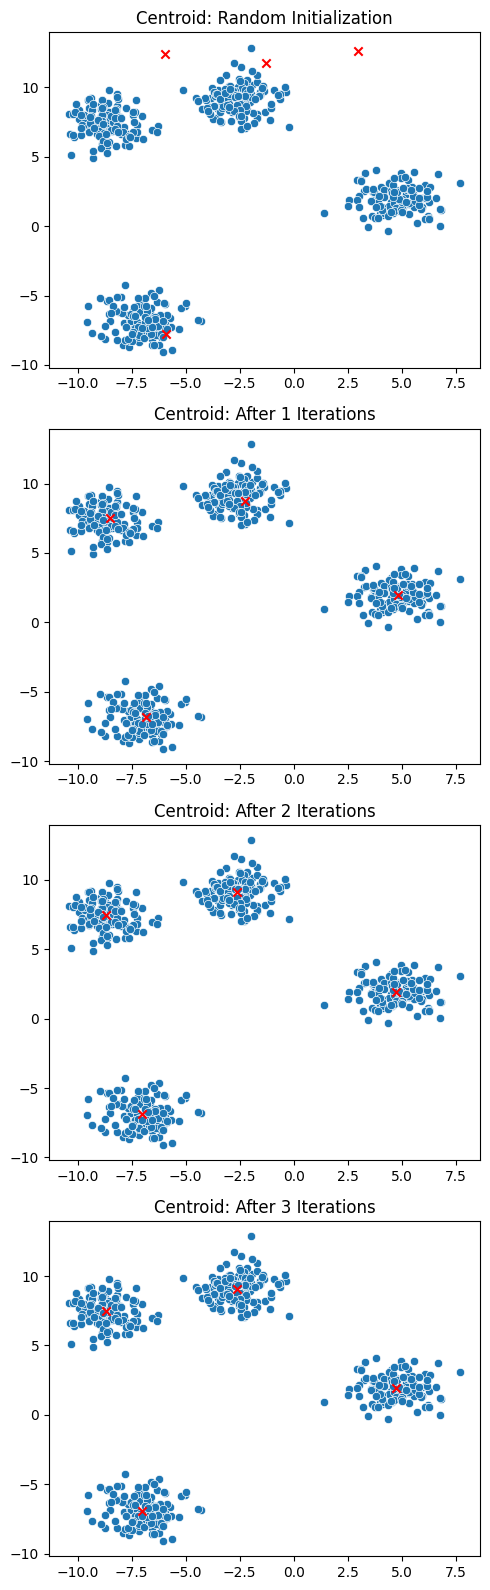

In [244]:
x_coords = [row[0] for row in X_2d]
y_coords = [row[1] for row in X_2d]

num_iterations = len(centroid_movement)

fig, ax = plt.subplots(num_iterations, figsize=(5,num_iterations * 4))

for index, centroid in enumerate(centroid_movement):
    title = "Centroid: Random Initialization" if index == 0 else f"Centroid: After {index} Iterations"
    plot_2d_results(x_coords, y_coords, centroid, title, ax[index])

plt.tight_layout()

## Comparison
Next lets compare our implementation on multi-dimensional data against the scikit-learn implementation. The scikit-learn implementation is much faster and more optimized since it uses numpy. It also uses an Expectation-Maximization algorithm instead of the basic mean distance implementation used by out model. We will initialize it with the same `1e-5` tolerance, and the random choice init method.

To score the models we will use the Davies Bouldin (lower is better) and Calinski Harabasz (higher is better) scores from the sklearn metrics module.

We will generate a dataset consisting of:
- 10000 data points
- 15 features
- 6 clusters

In [245]:
larger_example = make_blobs(n_samples=10000, n_features=15, centers=6, random_state=RANDOM_SEED)
larger_example_data = larger_example[0]

In [246]:
from sklearn.cluster import KMeans as sk_KMeans
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

In [247]:
custom_kmeans_multi = KMeans(6)
custom_kmeans_multi.fit(larger_example_data.tolist())
custom_kmeans_labels = custom_kmeans_multi.predict(larger_example_data.tolist())

sklearn_kmeans = sk_KMeans(6, init='random', tol=.00001)
sklearn_kmeans.fit(larger_example_data)
sklearn_kmeans_labels = sklearn_kmeans.predict(larger_example_data)

In [248]:
custom_davies_bouldin = davies_bouldin_score(larger_example_data, custom_kmeans_labels)
custom_calinski_harabasz = calinski_harabasz_score(larger_example_data, custom_kmeans_labels)

sklearn_davies_bouldin = davies_bouldin_score(larger_example_data, sklearn_kmeans_labels)
sklearn_calinski_harabasz = calinski_harabasz_score(larger_example_data, sklearn_kmeans_labels)

In [249]:
print("Davies Bouldin (lower is better)")
print(f"Custom model:       {custom_davies_bouldin}")
print(f"Scikit-learn model: {sklearn_davies_bouldin}")
print('\n')
print("Calinski Harabasz (higher is better)")
print(f"Custom model:       {custom_calinski_harabasz}")
print(f"Scikit-learn model: {sklearn_calinski_harabasz}")

Davies Bouldin (lower is better)
Custom model:       1.7930119220711058
Scikit-learn model: 0.27522623621752945


Calinski Harabasz (higher is better)
Custom model:       13169.854174984577
Scikit-learn model: 64118.16705648195


# Conclusion
Running this notebook multiple times it is clear that our custom implementation is far less reliable and much more inconsistent. This is because of the basic implementation that we used to calculate and update the cluster centers. For example if a center is equidistant between all points assigned to it even if it is in the middle of two clusters it will not update or move as it is already at the mean of all assigned data points. A better way would be to use the Expectation Maximization algorithm or a variant of it as used by scikit-learn.

In [250]:
from watermark import watermark
mark = watermark(author='Alexander Levin-Koopman', 
                 github_username='Alkoopman85', 
                 website='https://alkoopman85.github.io/')
print(mark)
print(watermark())
print('For the demonstration:')
print(watermark(packages='sklearn,seaborn,matplotlib'))

Author: Alexander Levin-Koopman

Github username: Alkoopman85

Website: https://alkoopman85.github.io/

Last updated: 2024-10-25T08:20:11.101634-07:00

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.28.0

Compiler    : GCC 14.2.1 20240910
OS          : Linux
Release     : 6.11.3-arch1-1
Machine     : x86_64
Processor   : 
CPU cores   : 12
Architecture: 64bit

For the demonstration:
sklearn   : 1.5.2
seaborn   : 0.13.2
matplotlib: 3.9.2

